In [1]:
%cd ..

c:\Users\nakag\c3\pbl-ssc_with_gfootball


In [2]:
import numpy as np
import pandas as pd
import swifter
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

from src.util import norm_xy_to_gfootball

In [3]:
p_real = 'data/unofficial/2023041506/tracking.csv'
p_sim = 'outputs/2025-06-22/01-05-57/simulated_tracking_data.csv'

real_df = pd.read_csv(p_real)
sim_df = pd.read_csv(p_sim)

use_col = ['HA', 'No', 'X', 'Y', 'Speed', 'Frame']
real_df = real_df[use_col]
sim_df = sim_df[use_col]
real_df['type'] = 'real'
sim_df['type'] = 'simulated'

In [4]:
real_df

,HA,No,X,Y,Speed,Frame,type
0,1,2,2302,-58,0.00,1444962,real
1,1,5,2019,-1458,0.00,1444962,real
2,1,10,1148,396,0.00,1444962,real
3,1,13,842,-1731,0.00,1444962,real
4,1,14,1839,-124,0.00,1444962,real
...,...,...,...,...,...,...,...
1026119,2,16,-2572,2168,3.30,1490697,real
1026120,2,18,-1449,2514,3.74,1490697,real
1026121,2,19,-2751,3365,1.61,1490697,real
1026122,2,23,-3324,1139,3.97,1490697,real


In [5]:
sim_df

,HA,No,X,Y,Speed,Frame,type
0,1,1,-1.011029e+00,-0.000000,0.000000,1,simulated
1,1,2,1.782200e-10,0.018732,0.002561,1,simulated
2,1,3,1.713400e-03,-0.021354,0.003166,1,simulated
3,1,4,-4.247252e-01,-0.197968,0.003443,1,simulated
4,1,5,-5.055147e-01,-0.064594,0.000000,1,simulated
...,...,...,...,...,...,...,...
69018,2,8,4.603239e-01,-0.271066,0.002805,3001,simulated
69019,2,9,3.086359e-01,0.196443,0.006402,3001,simulated
69020,2,10,1.204058e-01,-0.061461,0.006413,3001,simulated
69021,2,11,7.055316e-01,-0.230001,0.002802,3001,simulated


In [6]:
sim_total_frames = sim_df['Frame'].max() - sim_df['Frame'].min()
real_total_frames = real_df['Frame'].max() - real_df['Frame'].min()
print(f"Simulated total frames: {sim_total_frames}")
print(f"Real total frames: {real_total_frames}")

Simulated total frames: 3000
Real total frames: 45735


In [7]:
n_get_frames = 100
real_skip_frames = int(real_total_frames / n_get_frames)
sim_skip_frames = int(sim_total_frames / n_get_frames)

real_df = real_df[real_df['Frame'] % real_skip_frames == 0]
sim_df = sim_df[sim_df['Frame'] % sim_skip_frames == 0]

real_df[["X", "Y"]] = real_df.swifter.apply(
    lambda row: pd.Series(norm_xy_to_gfootball(row["X"], row["Y"])), axis=1
)

Pandas Apply:   0%|          | 0/2245 [00:00<?, ?it/s]

C:\Users\nakag\AppData\Local\Temp\ipykernel_10484\1282501106.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_df[["X", "Y"]] = real_df.swifter.apply(


<Axes: title={'center': 'Real Data Tracking'}, xlabel='X', ylabel='Y'>

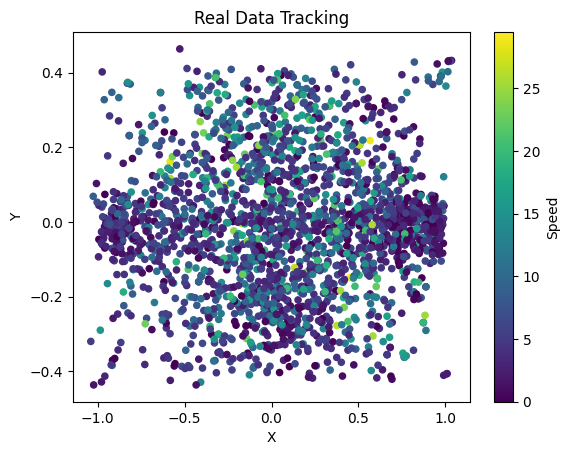

In [8]:
real_df.plot.scatter(
    x='X', y='Y', c='Speed', colormap='viridis', title='Real Data Tracking'
)

<Axes: title={'center': 'Simulated Tracking Data'}, xlabel='X', ylabel='Y'>

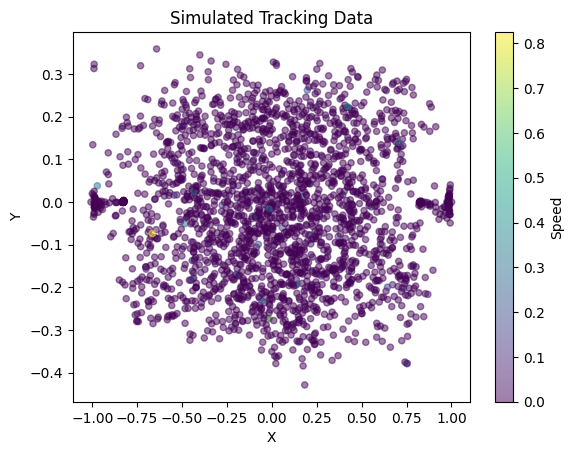

In [9]:
sim_df.plot.scatter(
    x='X', y='Y', c='Speed', colormap='viridis', alpha=0.5, title='Simulated Tracking Data'
)

In [25]:
# Remove ball information
real_df = real_df.loc[real_df['HA'] != 0]
sim_df = sim_df.loc[sim_df['HA'] != 0]

input_param = [
    'X', 'Y',
    # 'Speed'
]

n_iter = 100
train_ratio = 0.8
n_train_samples = int(n_get_frames * train_ratio)
importances = list()
accuracies = list()
aucs = list()
f1_scores = list()

for _ in range(n_iter):
    real_X = [np.array([sub_group.sample(frac=1).loc[:, input_param] for ha, sub_group in list(group.groupby('HA'))]).flatten() for _, group in list(real_df.groupby(['Frame', 'type']))]
    sim_X = [np.array([sub_group.sample(frac=1).loc[:, input_param] for ha, sub_group in list(group.groupby('HA'))][::-1]).flatten() for _, group in list(sim_df.groupby(['Frame', 'type']))]
    real_y = [True for _ in list(real_df.groupby(['Frame', 'type']))]
    sim_y = [False for _ in list(sim_df.groupby(['Frame', 'type']))]

    X_train = real_X[:n_train_samples] + sim_X[:n_train_samples]
    X_valid = real_X[n_train_samples:] + sim_X[n_train_samples:]
    y_train = real_y[:n_train_samples] + sim_y[:n_train_samples]
    y_valid = real_y[n_train_samples:] + sim_y[n_train_samples:]

    X_train = np.array(X_train)
    X_valid = np.array(X_valid)
    y_train = np.array(y_train)
    y_valid = np.array(y_valid)

    # 二値分類問題であるため、objectiveに'binary'を指定する
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': 100,
        'learning_rate': 0.1,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 42,
        'n_jobs': -1,
        'verbose': -1,
    }

    # モデルをインスタンス化する
    model = lgb.LGBMClassifier(**params)

    # モデルの学習を実行する
    # 早期停止を用いて、検証用データの評価指標が改善しない場合に学習を終了させる
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True)]
    )

    # 検証データに対して予測を行う
    # predict_probaはクラス1に分類される確率を返す
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    # 確率が0.5以上の場合をクラス1と予測する
    y_pred = (y_pred_proba > 0.5).astype(int)

    # モデルの性能を評価する
    accuracies.append(accuracy_score(y_valid, y_pred))
    aucs.append(roc_auc_score(y_valid, y_pred_proba))
    f1_scores.append(f1_score(y_valid, y_pred))

    # 特徴量の重要度を取得する
    importances.append(
        pd.DataFrame(
            {'feature': model.feature_name_, 'importance': model.feature_importances_}
        ).sort_values('importance', ascending=False)
    )

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[62]	valid_0's auc: 0.6775
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's auc: 0.6225
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	valid_0's auc: 0.7275
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	valid_0's auc: 0.695
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's auc: 0.5875
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	valid_0's auc: 0.7475
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 0.7975
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iterati

In [26]:
# print accuracies, aucs, f1_scores as mean +- std
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

Accuracy: 0.6393 ± 0.0674
AUC: 0.6988 ± 0.0721
F1 Score: 0.6259 ± 0.0770


In [35]:
combined_importance = pd.concat(importances, ignore_index=True)
combined_importance['feature_num'] = combined_importance['feature'].str.extract(r'(\d+)').astype(int)

# 0-22が片チーム、23-44がもう片チームの特徴量を含む.0-22の偶数がx座標、奇数がy座標 23-44の偶数がx座標、奇数がy座標
first_team_x_importance = combined_importance[(combined_importance['feature_num'] % 2 == 0) & (combined_importance['feature_num'] < 23)]
first_team_y_importance = combined_importance[(combined_importance['feature_num'] % 2 == 1) & (combined_importance['feature_num'] < 23)]
second_team_x_importance = combined_importance[(combined_importance['feature_num'] % 2 == 0) & (combined_importance['feature_num'] >= 23)]
second_team_y_importance = combined_importance[(combined_importance['feature_num'] % 2 == 1) & (combined_importance['feature_num'] >= 23)]

print("First Team X Importance:", first_team_x_importance['importance'].sum())
print("First Team Y Importance:", first_team_y_importance['importance'].sum())
print("Second Team X Importance:", second_team_x_importance['importance'].sum())
print("Second Team Y Importance:", second_team_y_importance['importance'].sum())

First Team X Importance: 6515
First Team Y Importance: 6283
Second Team X Importance: 5132
Second Team Y Importance: 6224


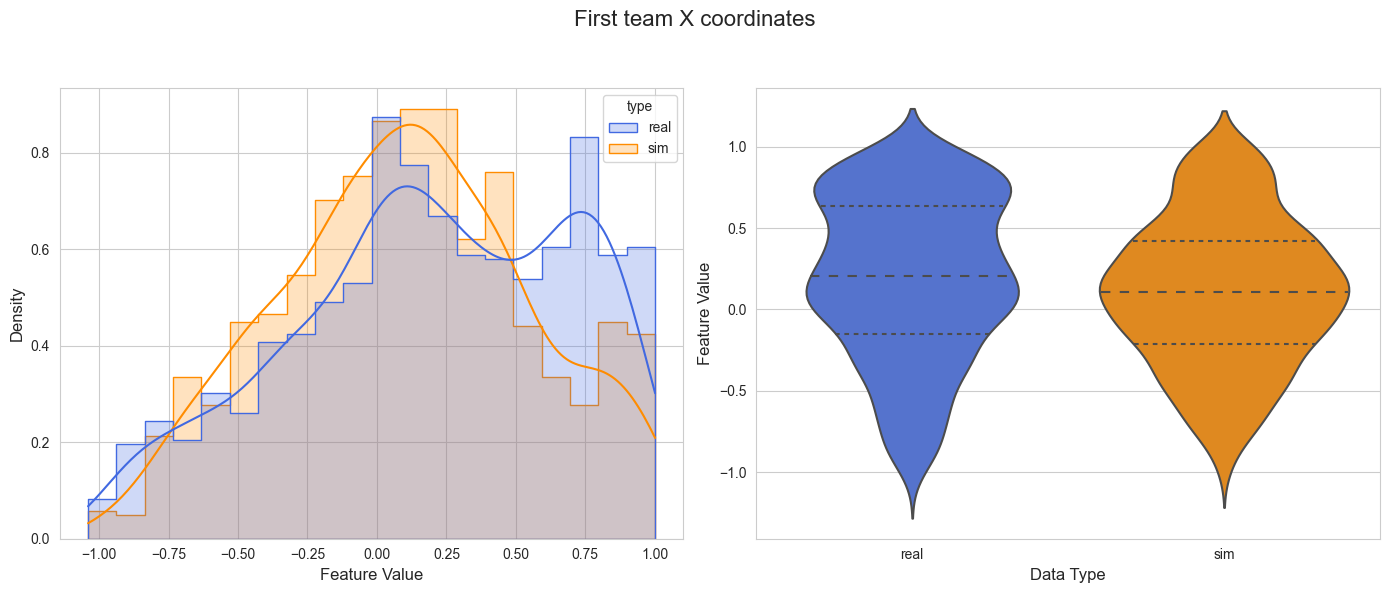

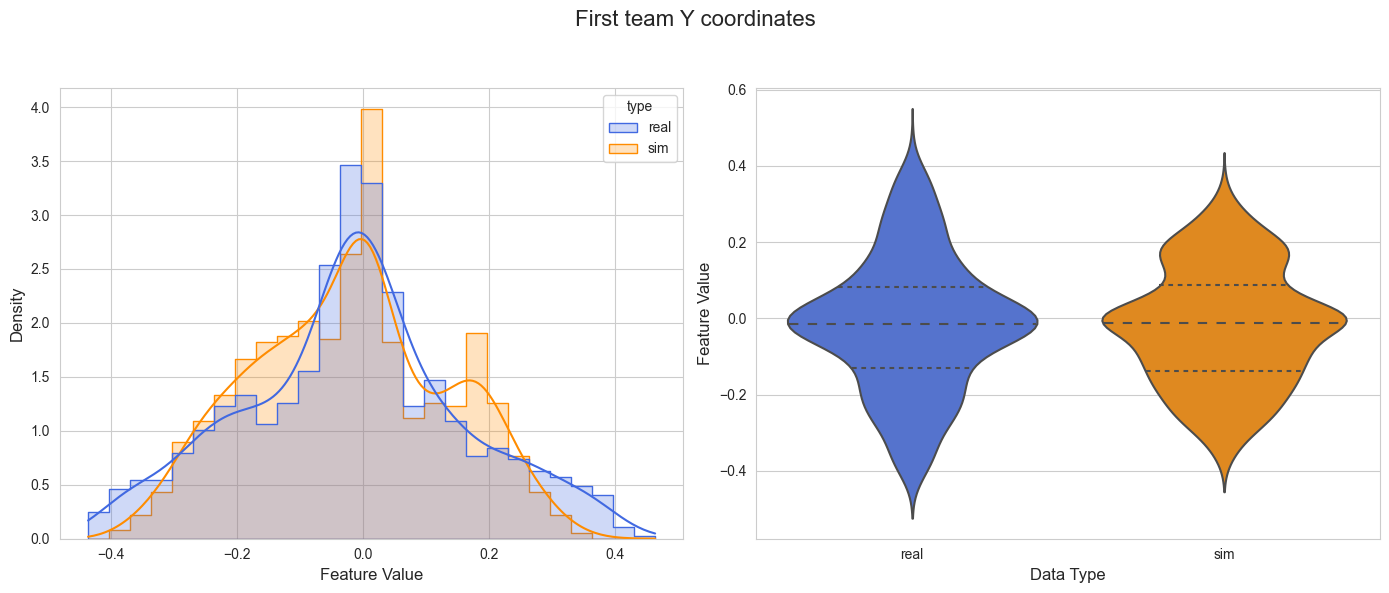

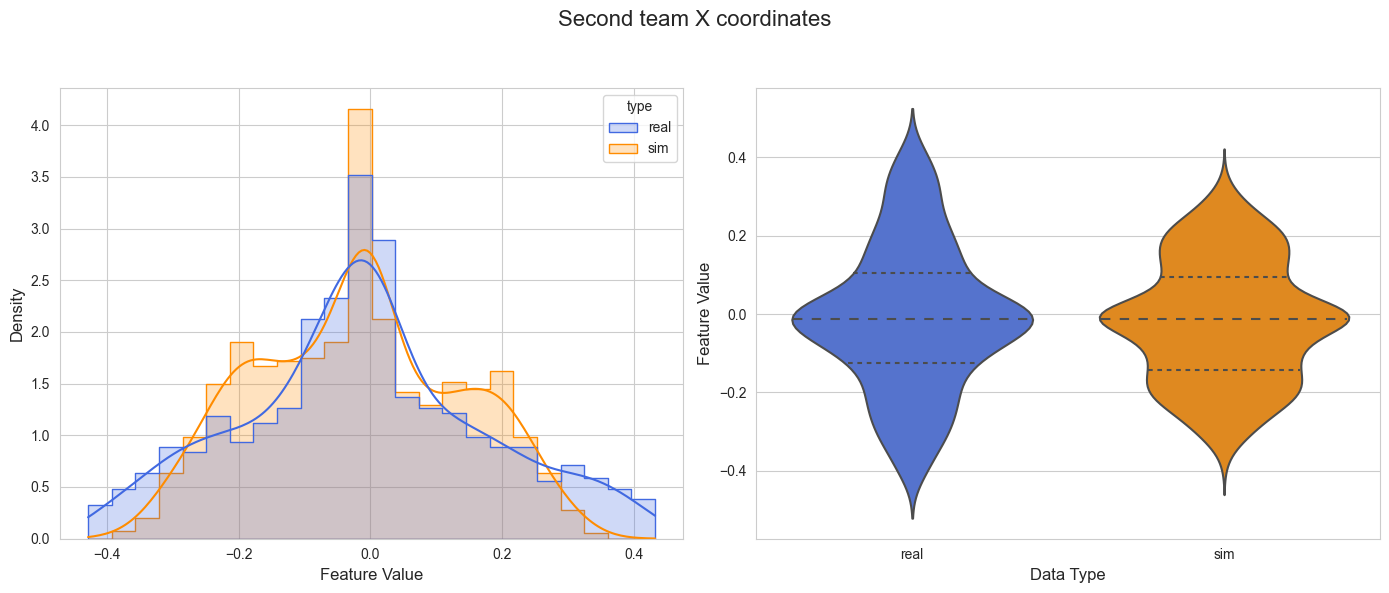

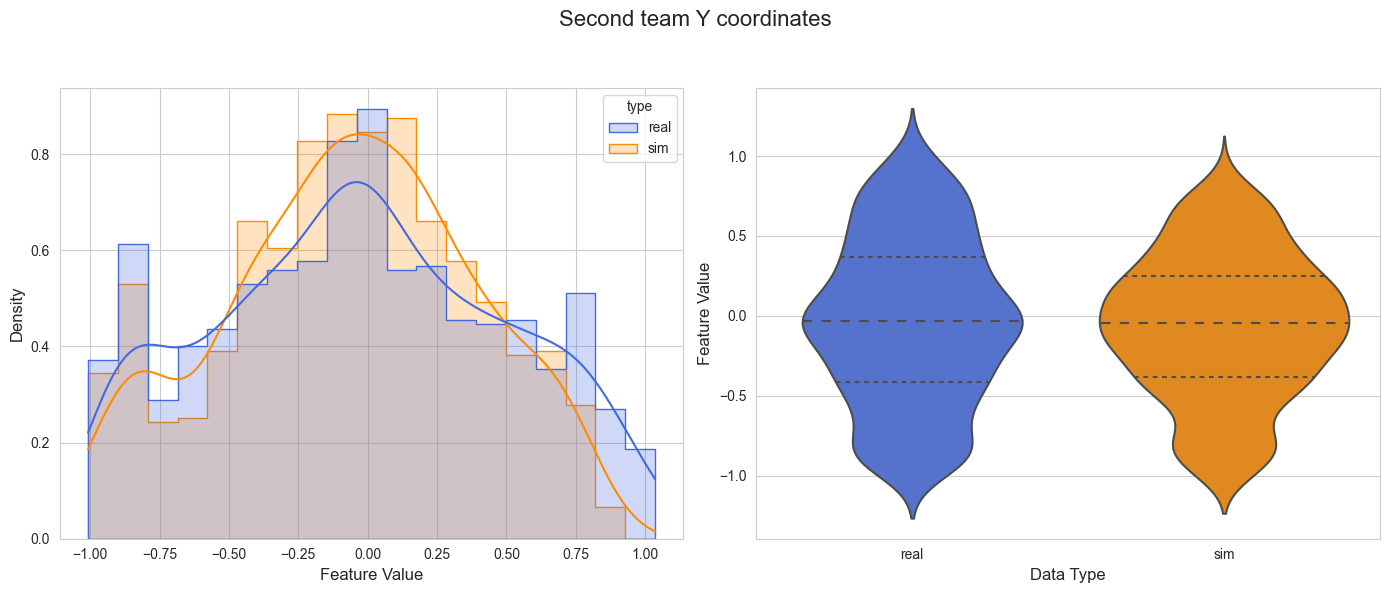

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

team_extract_idxs = {
    'First team X coordinates': [i for i in range(0, 23, 2)],  # First team X coordinates
    'First team Y coordinates': [i for i in range(1, 23, 2)],  # First team Y coordinates
    'Second team X coordinates': [i for i in range(23, 44, 2)],  # Second team X coordinates
    'Second team Y coordinates': [i for i in range(24, 44, 2)],  # Second team Y coordinates
}

for title, idx in team_extract_idxs.items():

    real_data = np.array(real_X)[:, idx].flatten()
    sim_data = np.array(sim_X)[:, idx].flatten()

    # 1. データを分析用のDataFrameに統合する
    # 各データに 'real', 'sim' のラベルを付与して結合する
    df_real = pd.DataFrame({'value': real_data, 'type': 'real'})
    df_sim = pd.DataFrame({'value': sim_data, 'type': 'sim'})
    combined_df = pd.concat([df_real, df_sim], ignore_index=True)

    # 2. 分布を可視化する
    # MatplotlibとSeabornのスタイルを設定する
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (14, 6)

    # 2.1. ヒストグラムとカーネル密度推定（KDE）プロットを重ねて描画
    plt.subplot(1, 2, 1)
    sns.histplot(data=combined_df, x='value', hue='type', kde=True, 
                palette={'real': 'royalblue', 'sim': 'darkorange'},
                element="step", stat="density", common_norm=False)
    plt.xlabel('Feature Value', fontsize=12)
    plt.ylabel('Density', fontsize=12)

    # 2.2. 箱ひげ図とヴァイオリンプロットを並べて描画
    # ヴァイオリンプロットは分布の形状も表現できるため、より多くの情報を含む
    plt.subplot(1, 2, 2)
    sns.violinplot(data=combined_df, x='type', y='value',
                palette={'real': 'royalblue', 'sim': 'darkorange'}, inner='quartile'
    )
    plt.xlabel('Data Type', fontsize=12)
    plt.ylabel('Feature Value', fontsize=12)

    # レイアウトを調整してプロットを表示
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.85)  # タイトルのスペースを確保
    plt.show()

In [ ]:
# print accuracies, aucs, f1_scores as mean +- std
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

Accuracy: 0.6393 ± 0.0674
AUC: 0.6988 ± 0.0721
F1 Score: 0.6259 ± 0.0770
